# Object-oriented-programmed Neural Network

### With standard binary classification and softmax

In [102]:
import numpy as np
import matplotlib.pyplot as plt

We define several classes :

- a "net" class that will be instantiated only once
```
net = Net('multi_cross_entropy')
```
- several "layer" classes, which will have to be instantiated Keras-style :
```
net.add(LayerFC(2,2))
net.add(LayerTanh())
net.add(LayerFC(2, 4))
net.add(LayerTanh())
net.add(LayerFC(4, 1))
net.add(LayerSigmoid())
```

In [113]:
class Net():
    
    def __init__(self, loss_type): # loss_type should be a string: 'bin_cross_entropy', 'multi_cross_entropy'...
        self.layers = []
        self.loss_type = loss_type
        
    def add(self, layer):
        self.layers.append(layer)
        
    def forward_pass(self, X):
        A = X
        for layer in self.layers:
            A = layer.forward(A)
        return A
        
    def bin_cross_entropy(self, A, Y):
        m = A.shape[1] #batch size
        loss = - (np.log(A) * Y + np.log(1 - A) * (1 - Y))
        cost = np.sum(loss) / m
        return cost
    
    def multi_cross_entropy(self, preds, labels):
        # preds: probabilities in a (nclasses, nexamples) array
        # labels: 1-0 in a (nclasses, nexamples) array (one-hot encoded)
        cross = np.multiply(preds, labels)
        cross = cross[cross != 0]
        cross = -np.log(cross)
        cross = np.mean(cross)
        return cross
        
    def backward_pass(self, dERROR, learning_rate):
        if self.loss_type == 'bin_cross_entropy':
            backward_list = reversed(self.layers)
        elif self.loss_type == 'multi_cross_entropy':
            backward_list = reversed(self.layers[0:-1])

        for layer in backward_list:
            dERROR = layer.backward(dERROR, learning_rate)
       
    def train(self, X, Y, learning_rate, epochs, prints_freq):

        self.costs = []
        
        for epoch in range(epochs):
            A = self.forward_pass(X)
            
            if self.loss_type == 'bin_cross_entropy':
                dERROR = - (Y/A) + ((1-Y)/(1-A))  # at this point dERROR = dJ/dAL
                curr_cross_entropy = self.bin_cross_entropy(A, Y)            
            elif self.loss_type == 'multi_cross_entropy':
                dERROR = A - Y # at this point dERROR = dJ/dZ
                curr_cross_entropy = self.multi_cross_entropy(A, Y)            

            if epoch % prints_freq == 0:
                print("Epoch:", epoch, "  Cost:", curr_cross_entropy)
                self.costs.append(curr_cross_entropy)
            
            self.backward_pass(dERROR, learning_rate)
        plt.plot(self.costs)
        
    def get_accuracy(self, A, Y):
        # get best-guess predictions
        preds = (A > 0.5) * 1
        # check how many such guesses were right
        correct_preds = (Y == preds)
        n_correct = np.sum(correct_preds)
        # get accuracy rate
        m = A.shape[1] # number of examples
        accuracy = n_correct / m
        return accuracy

We define 
- One "Fully-Connected" layer class
- Several activation layer classes

In [104]:
class LayerFC():
    
    def __init__(self, n_x, n_h):
        self.W = np.random.randn(n_h, n_x)
        self.b = np.zeros((n_h, 1))
    
    def forward(self, A_prev):
        self.A_prev = A_prev
        self.Z = np.dot(self.W, self.A_prev) + self.b
        return self.Z
    
    def backward(self, dERROR, learning_rate):
        m = dERROR.shape[1] #batch size
        dW = (1 / m) * np.dot(dERROR, self.A_prev.T)
        db = (1 / m) * np.sum(dERROR, axis=1, keepdims=True)
        dERROR = np.dot(self.W.T, dERROR)
        
        self.W = self.W - learning_rate * dW        
        self.b = self.b - learning_rate * db        
        
        return dERROR
    
class LayerSigmoid():
    
    def forward(self, Z):
        self.A = 1 / (1 + np.exp(-Z))
        return self.A
    
    def backward(self, dERROR, learning_rate):
        derivative = self.A * (1 - self.A)
        dERROR = dERROR * derivative        
        return dERROR

class LayerTanh():    
    def forward(self, Z):
        self.A = np.tanh(Z)
        return self.A
    
    def backward(self, dERROR, learning_rate):
        derivative = 1 - np.square(self.A)
        dERROR = dERROR * derivative
        return dERROR

#ReLU doesn't seem to deliver even remotely correct perfs with our simple datasets.
    
class LayerSoftmax():    
    def forward(self, Z):
        self.t = np.exp(Z)
        exps_sum = np.sum(self.t)
        self.A = self.t / exps_sum
        return self.A


#### Generating examples

In [105]:
# def gen_xor_examples(sample_size):
#     X = np.random.randn(2,sample_size)
#     mask1 = X[0, :] > 0
#     mask2 = X[1, :] > 0
#     mask3 = X[0, :] < 0
#     mask4 = X[1, :] < 0
#     Y = ((mask1 & mask2) | (mask3 & mask4)) * 1
#     Y = Y.reshape(1, Y.shape[0])
#     return X, Y

# X_train_XOR, Y_train_XOR = gen_xor_examples(1000)
# X_test_XOR, Y_test_XOR = gen_xor_examples(200)

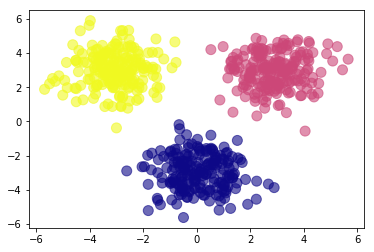

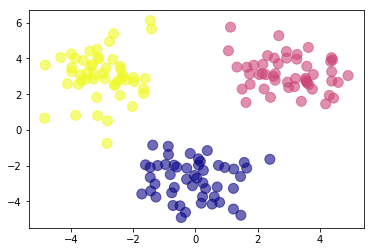

In [106]:
def gen_3plasma_zones(sample_size, show_dist=False):
    
    typeA = np.random.randn(sample_size, 2) + np.array([0, -3])
    typeB = np.random.randn(sample_size, 2) + np.array([3, 3])
    typeC = np.random.randn(sample_size, 2) + np.array([-3, 3])

    X = np.vstack([typeA, typeB, typeC]).T 
    Y_temp = np.array([0]*sample_size + [1]*sample_size + [2]*sample_size)
    
    Y = np.zeros((3, sample_size * 3))
    for i in range(sample_size * 3):
        Y[Y_temp[i], i] = 1

    if show_dist:
        plt.scatter(X[0, :], X[1, :], c=Y_temp, cmap='plasma', s=100, alpha=0.6)  
        plt.show()
    
    return X, Y, Y_temp

X_train_multi, Y_train_multi, _ = gen_3plasma_zones(200, True)
X_test_multi, Y_test_multi, _ = gen_3plasma_zones(50, True)

In [111]:
net = Net('multi_cross_entropy')
# net = Net('bin_cross_entropy')
net.add(LayerFC(2,2))
net.add(LayerTanh())
net.add(LayerFC(2, 3))
net.add(LayerTanh())
net.add(LayerFC(3, 3))
net.add(LayerSoftmax())

Epoch: 0   Cost: 7.879165575693337
Epoch: 250   Cost: 6.907476908958141
Epoch: 500   Cost: 6.924326927016846
Epoch: 750   Cost: 6.974003673245961
Epoch: 1000   Cost: 7.027484233302396
Epoch: 1250   Cost: 7.084191201189467
Epoch: 1500   Cost: 7.14394582758985
Epoch: 1750   Cost: 7.206643618213657
Epoch: 2000   Cost: 7.272178136296787
Epoch: 2250   Cost: 7.340421509612461
Epoch: 2500   Cost: 7.41122191720218
Epoch: 2750   Cost: 7.484407269744795


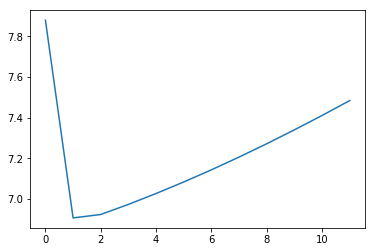

In [112]:
# %debug
net.train(X_train_multi, Y_train_multi, epochs=3000, learning_rate=0.11, prints_freq=250)

In [72]:
r = net.forward_pass(X_test)

In [24]:
net.get_accuracy(r, Y_test)

1.44